**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import scipy as sp 
import numpy as np
from scipy import optimize
from types import SimpleNamespace
import matplotlib.pyplot as plt 
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
from scipy import interpolate

%load_ext autoreload
%autoreload 2

import Question1 as Q1
import Question2 as Q2


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor



The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.



**Answer 1:** 

To verify we; 
* define various functions and parameters in a SimpleNamespace called bl ('baseline')
* define both the given analytical solution, `L_opt_analytical()`, and `L_opt(G, bl)` which uses SciPy optimization (Nelder-Mead with bounds on L $\in (0,24))$
* run both the analytical solution and the SciPy optimizer function for $G \in \{1.0,2.0\}$ and find that $L^\star(\tilde w)≈ 15.3$ for both functions and instances of $G$

This is as expected, as it follows from the analytical solution that $^\star$ does not depend on G, but on dispensible income as well as the parameters of the model. 

In [2]:
bl = SimpleNamespace()
bl.alpha = 0.5
bl.kappa = 1.0
bl.nu = 1/(2*16**2)
bl.w = 1
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w
bl.sigma = 1.001
bl.rho = 1.001
bl.eps = 1


In [3]:
# Given list of G values
G_list = [1.0, 2.0]

# Define bl.w_tilde
bl.w_tilde = (1 - bl.tau) * bl.w

# Calculate numerical solutions for optimal labor input
solutions = Q1.L_opt(G_list, bl)
solution = list(solutions)

# Calculate analytical solutions for optimal labor input
solution_analytical = Q1.L_opt_analytical(bl, G_list)

# Print the results
print(f"The estimated solutions for G=1 and G=2, respectively, are {solution}")
print(f"The analytical solutions for G=1 and G=2, respectively, are {solution_analytical}")


The estimated solutions for G=1 and G=2, respectively, are [15.301684570312506, 15.301684570312506]
The analytical solutions for G=1 and G=2, respectively, are [15.30165022719559, 15.30165022719559]


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.


**Answer 2:**

*Figure 1* shows how $L^\star(\tilde w) = L^\star((1-\tau)w)$ depends on $w$

To construct the figure we:
* initialize empty Numpy arrays for the solutions and create a grid of $w$'s
* we then iterate `L_opt(G,bl)` over all $w$'s, store the results in the empty arrays, and plot the figure

We notice that there is both a negative and positive effect on labour hours in the analytical solution given above. Ultimately though, we can see that the effect on labour hours from icreased wage is positive.

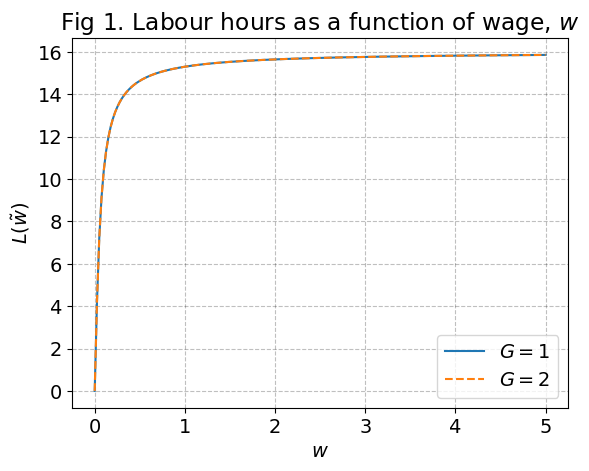

In [4]:
# Create grids
ws = np.linspace(0,5,200)
sols = np.empty((2,200))
sol_1 = np.empty(200)
sol_2 = np.empty(200)

# iterate and unnpack solution for each G
for i,w in enumerate(ws):
    bl.w = w
    sols = Q1.L_opt(G_list, bl)
    sols_list = list(sols)
    sol_1[i] = sols_list[0]
    sol_2[i] = sols_list[1]

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ws,sol_1, label = '$G=1$')
ax.plot(ws,sol_2,'--', label = '$G=2$')

ax.set_title(r"Fig 1. Labour hours as a function of wage, $w$")
ax.set_ylabel(r'$L(\tilde w)$')
ax.set_xlabel('$w$')
ax.legend()

# reset w and w_tilde
bl.w = 1.0
bl.w_tilde = (1-bl.tau)*bl.w






We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.



**Answer 3:**

*Figure 2* beneath shows the implied $L$, $G$ and worker utility for a grid of $\tau$'s. To construct, we:
* define the implied function for $G$ and and the analytical solution, not looping over $G$ as previously
* for each of $L$, $G$ and utility, $V$, we iterate over a grid of $\tau$'s and plot the three variables as a funciton of $\tau$ in *Figure 2* beneath
    * labour hours are strictly decreasing with $\tau$
    * government spending and worker utility are increasing and then decreasing, implying the existance of an optimal value, $\tau^\star$, that maximizes them both, respectively (id est the Laffer Curve)

When iterating, we use the analytical solution to find the number of labour hours, given $\tau$ since it does not depend on G in equilibrium. When then use that, $L$ to to calculate the corresponding G and lastly calculate the worker utility. 

/Users/felixjohannespettersson/Documents/projects-2023-scb/examproject/Question1.py:58: RuntimeWarning: invalid value encountered in double_scalars
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


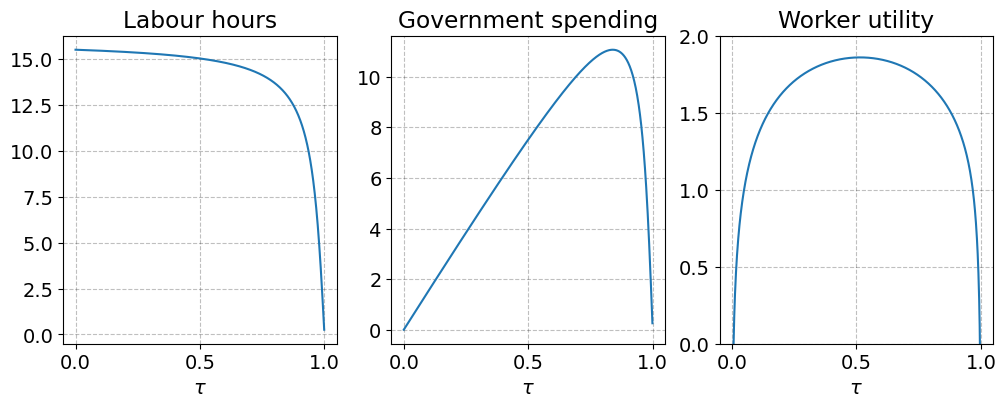

In [5]:
#Call funciton
tau_grid, L_vec, G_vec, V_vec = Q1.iterate_over_tau(bl)    

# Plot figures
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
ax.plot(tau_grid, L_vec)
ax.set_title('Labour hours')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,2)
ax.plot(tau_grid, G_vec)
ax.set_title('Government spending')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,3)
ax.plot(tau_grid, V_vec)
ax.set_title('Worker utility')
ax.set_xlabel(r'$\tau$')
ax.set_ylim(0,2)

# reset tau and w_tilde
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w

    

 


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

**Answer 4:**

To find the optimal tax we use the approach of finding the maximizing argument.
* We run `iterate_over_tau()` and find the maximizing argument (ie. maximizing index)
* then we find $\tau$ for that index to be ~ $51.4\%$
* We plot the tax in *Figure 3* below

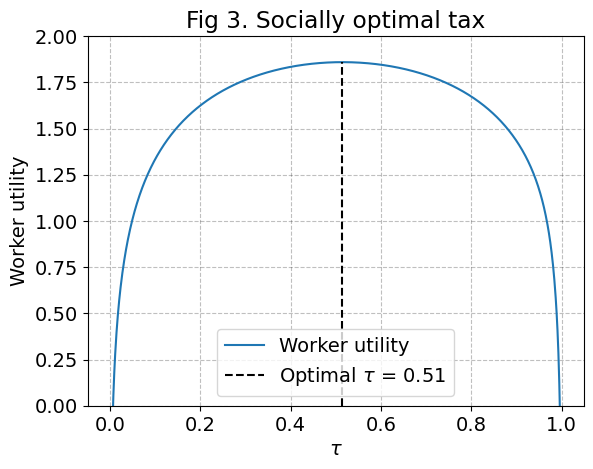

In [6]:
# Identify the maximum V and find the corresponding tau
tau_grid, L_vec, G_vec, V_vec = Q1.iterate_over_tau(bl)   
argmax_index = np.argmax((np.nan_to_num(V_vec)))
tau_opt  = tau_grid[argmax_index]

# Illustrate in figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_grid, V_vec, label = 'Worker utility')
ax.vlines(tau_opt,0,np.max(np.nan_to_num(V_vec)), linestyles='--', colors='black', label = fr'Optimal $\tau$ = {tau_opt:.2f}')
ax.set_ylim(0,2)
ax.set_ylabel('Worker utility')
ax.set_xlabel(r'$\tau$')
ax.set_title('Fig 3. Socially optimal tax')
ax.legend()

# reset tau and w_tilde
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w_tilde



A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Answer 5:**

To find the G that solves the equation, we define various functions, listed below:

* We define parameters and functions for calculating $C, G$ and the utility with `objective_function()`
* Function `solve_for_given_G()` solves for L for a given level of G and $\tau$ (here  $\tau^\star$) as the name states
* Function `find_opt_G()`iterates `solve_for_given_G()` over a grid og $G$ and finds the pair of $G$ and $L$ that satisfies the constraint
* For each of the two parameter values of $\sigma, \rho = \{1.001,1.5\}$ we find the pair of G and L given $\tau^\star$ and plot G as well as the deviation from the constraint in *Figure 4a* and *Figure 4b*

We notice that when $\rho, \sigma = 1.001$ the worker utility is approximately a Cobb-Douglas function


for rho, sigma = 1.001
G = [7.71099534] corresponds to L = 14.986962890625007  and minimizes the difference G - tau_opt*w*L = 0.01561922691337525
for rho, sigma = 1.5
G = [4.97509438] corresponds to L = 9.671630859374995  and minimizes the difference G - tau_opt*w*L = 0.006254623369768453


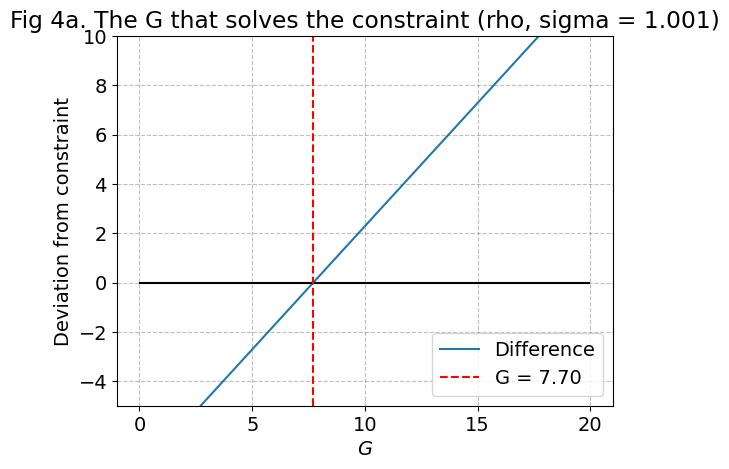

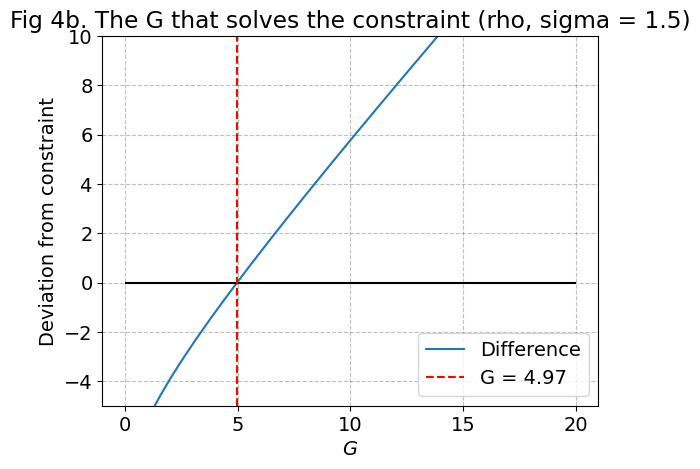

In [7]:
# define list of parameter values for rho and sigma 
par_list =[1.001,1.5]
letter_list = ['a','b']

# plot figures for each of the two parameter values
for i in [0,1]:
    bl.rho = par_list[i]                    # set parameter values
    bl.sigma = par_list[i]                  # set parameter values
    Gs, Ls, diffs, utility, tau = Q1.find_opt_G(bl, tau_opt) # run function optimzing over  
    print(fr'for rho, sigma = {bl.rho}')
    diffs_grid = interpolate.RegularGridInterpolator([Gs], diffs, bounds_error=False, fill_value=None)
    gx = lambda x: diffs_grid([x])[0]
    x_init = 0.2
    satisfaction_G = optimize.root(gx, x0=x_init).x
    print(f'G = {satisfaction_G} corresponds to L = {Ls[np.argmin(np.abs(diffs))]}'
      ,f' and minimizes the difference G - tau_opt*w*L = {np.min(np.abs(diffs))}')
    fig, ax = plt.subplots(1,1)
    ax.plot(Gs, diffs, label = 'Difference')
    ax.hlines(0, xmin=0, xmax=20, colors='black')
    ax.vlines(Gs[np.argmin(np.abs(diffs))], ymin=-5, ymax=16, linestyles="--", colors='red', label=f'G = {Gs[np.argmin(np.abs(diffs))]:.2f}')
    ax.set_ylim(-5,10)
    ax.legend(loc='lower right')
    ax.set_title(fr'Fig 4{letter_list[i]}. The G that solves the constraint (rho, sigma = {par_list[i]})')
    ax.set_ylabel('Deviation from constraint')
    ax.set_xlabel('$G$')

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Answer 6:**

We now have to find the socially optimal $\tau$. For each level of $\tau$ a pair of G and L exists that satisfies the equation above. The $\tau$ that maximizes worker utility is the socially optimal level of taxation. 

We would expect results similar to those of the Cobb-douglas from earlier for  $\rho, \sigma = 1.001$ and less so for $\rho, \sigma = 1.5$

To find the optimal tax rate we:
* We define G as $G = \tau w L$ in the Valuefunction $\mathcal{V}$ we then optimize the value function over $\tau$ and $L$ using scipy. 

We find that the optimizer is sensitive to the starting values, and as such we optimize with a multistart approach.

In [8]:
Utilities = dict({1:[], 2:[]})
for i in [0,1]:
    bl.rho = par_list[i]
    bl.sigma = par_list[i]
    np.random.seed(1234)
    x01 = np.random.uniform(0, 24, 20)
    x02 = np.random.uniform(0,1, 20)
    Utilities[i+1] = list()
    from tqdm import tqdm
    for o in tqdm(x01):
        for x in x02:
            x0 = [o, x]
            top_dawg = Q1.sol_G_L(bl,x0)
            Utilities[i+1].append([-top_dawg.fun, top_dawg.x[0], top_dawg.x[1]])

100%|██████████| 20/20 [00:00<00:00, 33.78it/s]


In [9]:
maximum_1 = Utilities[1][np.argmax(Utilities[1][0])]
maximum_2 = Utilities[2][np.argmax(Utilities[2][0])]

for i, x in [("par set 1", maximum_1),( "par set 2", maximum_2)]:
    print(f"for {i} the maximum utility is  {x[0]:.2f} and tau {x[2]:.2f}, with a labour supply of {x[1]:.2f}")

for par set 1 the maximum utility is  1.97 and tau 0.52, with a labour supply of 22.11
for par set 2 the maximum utility is  1.08 and tau 0.54, with a labour supply of 13.34


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [10]:
# define parameter namespace
par = SimpleNamespace()
par.eta = 0.5
par.w = 1.0
kappa = [1.0, 2.0]

# call function to verify
res = Q2.sol_ell(par, kappa)
opt_anal = Q2.ell_opt_anal(par, kappa)
print(res[0].x, res[1].x,opt_anal)


[0.25] [1.] [0.25, 1.0]


Optimizing numerically we find the same solution as the analytical solution. We can check this further by using the numpy "isclose" function, using this we again find that the numerical and analytical solution is the same:

In [11]:
print(np.isclose(res[0].x,opt_anal[0]),
np.isclose(res[1].x, opt_anal[1]))

[ True] [ True]


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [12]:
# define new parameters
par.rho = 0.90
par.iota = 0.01
par.sigma = 0.1
par.R = (1+0.01)**(1/12)
par.K = 500
par.kappa_init = 1
par.T = 120
par.Delta = 0

With above functions we can calculate the expected value of future profits. we plot the results for different Ks to check if K affects the result much. We choose to go with k=1000 for the rest of the assignment.

Text(0, 0.5, 'Expected profits')

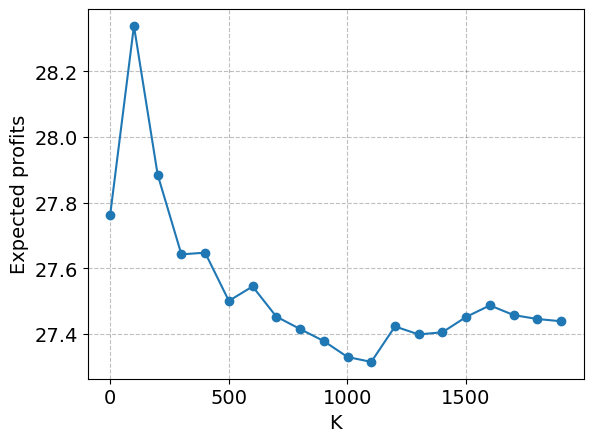

In [13]:
par.Delta = 0
Ks = np.arange(1, 2000, step=100)

prof_Delta_0 = np.zeros(len(Ks))

for i,K in enumerate(Ks):
    par.K = K
    np.random.seed(1234)
    prof_Delta_0[i] = Q2.big_H(par)

fig, ax = plt.subplots(1,1)
ax.plot(Ks, prof_Delta_0, marker='o')
ax.set_xlabel('K')
ax.set_ylabel('Expected profits')

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [14]:
# write your code here
par.Delta= 0.05
par.K = 1000
np.random.seed(1234)
profits_high_Delta = Q2.big_H(par)
print(f"Profits for high delta {profits_high_Delta:.3f},\n Profits delta =0 {prof_Delta_0[10]:.3f}")

Profits for high delta 28.004,
 Profits delta =0 27.330


We see that profitability is improved for a higher $\Delta$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [15]:
# Set K
par.K = 1000

# run  optimizer to find optimal Delta
optimalDelta = Q2.sol_Delta(par)
print(f"The optimal solution is {optimalDelta.x[0]:.3f}")

The optimal solution is 0.075


We can illustrate this in a plot with delta on the x axis an profits on the y-axis. The code takes a little long to run.

In [16]:
from tqdm import tqdm 
par.K = 1000
H = np.empty(100)
Delta = np.linspace(0,0.5,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    np.random.seed(1234)
    H[i] = Q2.big_H(par)

100it [01:06,  1.51it/s]


Text(0, 0.5, 'Expected profits')

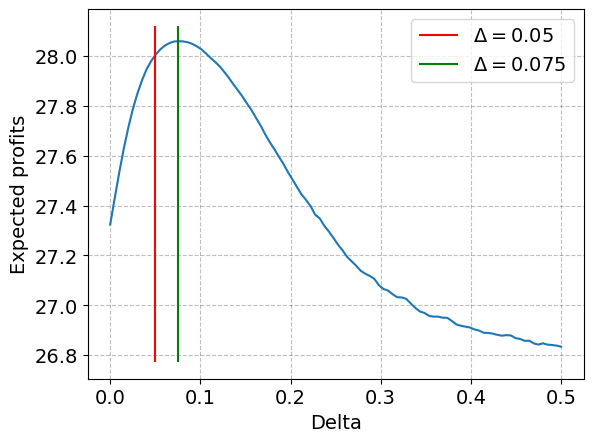

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]
# Add a vertical line at x=3 aligned with the top and bottom of the figure
ax.vlines(x=0.05, ymin=ymin, ymax=ymax, color='r', label="$\Delta = 0.05$")
ax.vlines(x=optimalDelta.x[0], ymin=ymin, ymax=ymax, color='g', label="$\Delta = 0.075$")
ax.legend()
ax.set_xlabel('Delta')
ax.set_ylabel('Expected profits')


Here it we can see that there is an obvious peak around $\Delta=0.075$


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



Instead of constantly changing the work force, we, as hair salon owners, consider only changing it after every $\gamma$-periods.
We can write the policy as

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if } t \bmod \gamma = 0, \\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\
 \gamma \in {1,2,\dots} 

$$
Choosing $ \gamma = 1 $ will therefore give us the same results, as in **Question 2**.

We write up our alternative functions, following previous notation:

As before, we maximize the profit of the company, now with regards to gamma. We do this for different values of iota aswell, to illustrate the dynamics between the two parameters.

In [18]:
# a. choose settings
# i. trade off: speed / accuracy
par.K = 400

# ii. specify values for loop 
N_gamma = 10 # number of fixed periods
N_iota = 4  # number of adjustment costs
max_iota = 0.03

fixed_periods = range(1, N_gamma+1)
iota_values = np.linspace(0,max_iota,N_iota)

# b. loop over different values of gamma and iota and store in H_matrix
H_matrix = np.empty((N_iota, N_gamma))
for j,iota in tqdm(enumerate(iota_values)):
    par.iota = iota 
    for i, fixed_period in enumerate(fixed_periods):
        par.gamma = fixed_period 
        np.random.seed(1234)
        H_matrix[j,i] = Q2.big_H_alt(par)

4it [00:06,  1.62s/it]


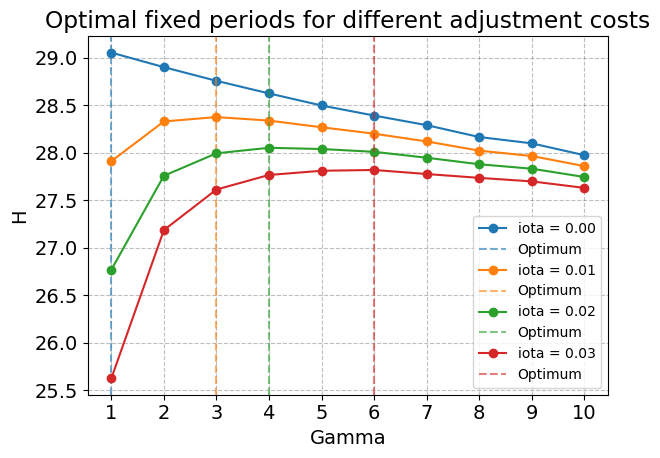

In [19]:
# c. plot results 
# i. main 
fig, ax = plt.subplots(1,1)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for j in range(N_iota):
    ax.plot(fixed_periods, H_matrix[j,], 
            color=colors[j], 
            label=f'iota = {iota_values[j]:0.2f}',
            marker='o')
    ax.axvline(x=np.argmax(H_matrix[j,])+1, 
               color=colors[j], 
               label='Optimum',
               linestyle='--', 
               alpha=0.6)

# ii. title, labels and ticks 
ax.set_title('Optimal fixed periods for different adjustment costs') 
ax.set_xlabel('Gamma')
ax.set_ylabel('H')
ax.set_xticks(fixed_periods)

# iii. legend
ax.legend(fontsize = 10)

fig.tight_layout();

From the figure, we see profit distributed on intervals of fixed contract periods, gamma, for different adjustment costs, iota. <br>
Intuitively, we see that if there are no adjustment costs, then the optimal value for gamma is 1, i.e. change labor supply every day to the optimal. By increasing the interval of fixed labor supply the total revenue declines, as there are more periods, where they can't behave optimaly, other things being equal. <br>
However, when the adjustment costs increases, we see that the optimal choice of interval for fixed labour supply, also increases. By raising the adjustment cost from 0 to 0.01, the optimal fixed periods go from 1 to 3. Which gives an increas of revenue!  <br>
We therefore conclude that in the presence of adjustment costs, it would be profitable not to adjust labor supply every period.


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [20]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [21]:
# 1. generate our global optimizer with refined multi-start.

def glob_opt_multi_start(f, lower_bound, upper_bound, tol, K_warm_up, K_max):
    """
    Perform global optimization using the multi-start approach.

    Parameters:
    - f (callable): objective function to be minimized.
    - lower_bound (float): lower bound(s) for the optimization variables.
    - upper_bound (float): upper bound(s) for the optimization variables.
    - tol (float): Tolerance for convergence in algorithm and optimizer. 
    - K_warm_up (int): number of initial iterations without refinement.
    - K_max (int): maximum number of iterations.

    Returns:
    - x_star (ndarray): optimal solution found.
    - x_k0s (list): list of initial guesses used in each iteration.
    """

    
    x_k0s = [] # store initial guesses  

    for k in range(K_max):

        # 3A: draw random x_k uniformly within chosen bounds
        x_k = np.random.uniform(lower_bound, upper_bound, size=(2))

        if k < K_warm_up: # then go to 3E
            # 3B: no refinement
            x_k0 = x_k # KJT ADDED THIS !

        else:
            # 3C: calculate chi_k
            chi_k = 0.5 * 2 / (1 + np.exp((k - K_warm_up) / 100))
            
            # 3D: Refine x_k0 using chi_k and x_star
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star

        # 3E: run optimizer & store initial guess
        x_kstar = optimize.minimize(f, x0=x_k0, method='BFGS', tol=tol) 
        x_k0s.append(x_k0)

        # 3F: update x_star if better
        if k == 0 or f(x_kstar.x) < f(x_star):
            x_star = x_kstar.x
       
        # 3G: check termination condition
        if f(x_star) < tol:
            print('break')
            break

    return x_star, x_k0s


In [22]:
# 2. specify settings 
lower_bound = -600
upper_bound = 600
tol = 1e-8
K_warm_up = 10
K_max = 1000

# 3. run optimizer on griewank & check results 
np.random.seed(1234) # for reproducibility 
x_star,x_k0s  = glob_opt_multi_start(griewank, lower_bound, upper_bound, tol, K_warm_up, K_max)

print(f'x_star = {x_star}')
print(f'x_star == [0,0] = {np.isclose(x_star,[0,0])}')
print(f'k={len(x_k0s)}-simulations')

break
x_star = [-6.93082502e-09  5.99902737e-09]
x_star == [0,0] = [ True  True]
k=230-simulations


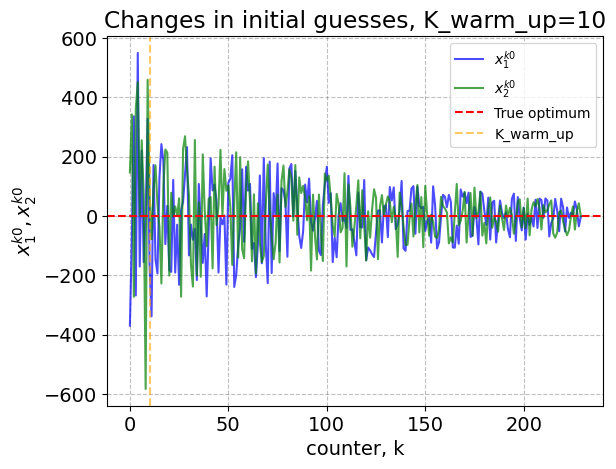

In [23]:
# 4. unpack initial guesses
x_k0_1s = [i[0] for i in x_k0s ]
x_k0_2s = [i[1] for i in x_k0s ]
k = np.arange(len(x_k0_1s))

# 5. plot results 
# a. main 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# b. plot values 
# i. for x_k0-values 
ax.plot(k, x_k0_1s, 'b-', alpha=0.7, label='$x^{k0}_1$')
ax.plot(k, x_k0_2s, 'g-', alpha=0.7, label='$x^{k0}_2$')

# ii. lines on axis
plt.axhline(y=0, color='r', linestyle='--', label='True optimum')
plt.axvline(x=K_warm_up, color='orange', alpha=0.6, linestyle='--', label='K_warm_up')

# c. title and labels  
ax.set_title(f"Changes in initial guesses, K_warm_up={K_warm_up}" )
ax.set_xlabel('counter, k')
ax.set_ylabel('$x^{k0}_1, x^{k0}_2$')

# d. legend
ax.legend(loc='upper right', fontsize=10);

As we can see from the figure, there seems to be a higher variation in the initial guesses, when we are in 'the warm-up'-period, $[0, \underline{K} ]$. <br>
Afterwards the initial guesses slowly converges toward the true optimum, which suggests that the revized initial guess from 3D, increases the speed of convergence. <br>


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [24]:
# we rerun previous code, with the new change in K_warm_up!

# 2. specify settings 
lower_bound = -600
upper_bound = 600
tol = 1e-8
K_warm_up = 100 # changed!
K_max = 1000

# 3. run optimizer on griewank & check results 
np.random.seed(1234) # for reproducibility 
x_star,x_k0s  = glob_opt_multi_start(griewank, lower_bound, upper_bound, tol, K_warm_up, K_max)

print(f'x_star = {x_star}')
print(f'x_star == [0,0] = {np.isclose(x_star,[0,0])}')
print(f'k={len(x_k0s)}-simulations')

break
x_star = [-7.91600055e-09  9.46688217e-10]
x_star == [0,0] = [ True  True]
k=334-simulations


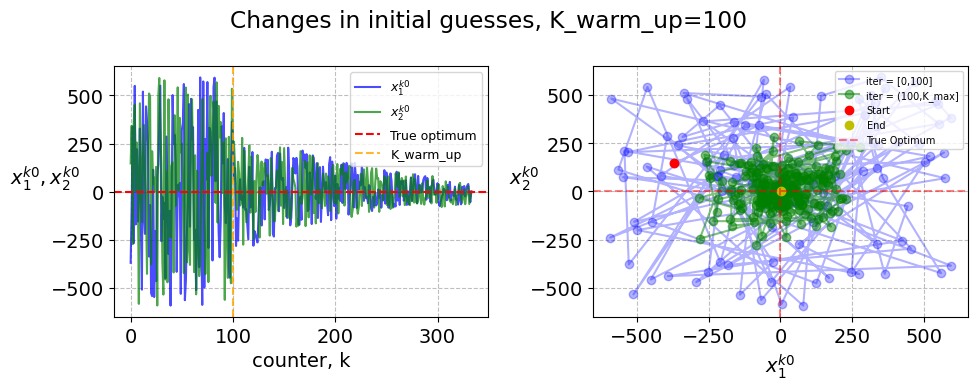

In [25]:
# 4. unpack initial guesses
x_k0_1s = [i[0] for i in x_k0s ]
x_k0_2s = [i[1] for i in x_k0s ]
k = np.arange(len(x_k0_1s))

# 5. plot results 
fig = plt.figure(figsize = (10,4))
fig.suptitle(f'Changes in initial guesses, K_warm_up={K_warm_up}')

# a. left plot 
ax = fig.add_subplot(1,2,1)

# i. plot variables 
ax.plot(k, x_k0_1s, 'b-', alpha=0.7, label='$x^{k0}_1$')
ax.plot(k, x_k0_2s, 'g-', alpha=0.7, label='$x^{k0}_2$')

# ii. lines on axis
ax.axhline(y=0, color='r', linestyle='--', label='True optimum')
ax.axvline(x=K_warm_up, color='orange', alpha=0.8, linestyle='--', label='K_warm_up')

# iii. title and labels  
ax.set_xlabel('counter, k')
ax.set_ylabel('$x^{k0}_1, x^{k0}_2$', rotation = 'horizontal')

# iv. legend
ax.legend(loc='upper right', fontsize=9)


# b. right plot 
ax = fig.add_subplot(1,2,2)

# i. variables 
ax.plot(x_k0_1s[:100], x_k0_2s[:100], 'b-', alpha=0.3, label='iter = [0,100]',marker ='o')  # first 100 observations with blue color
ax.plot(x_k0_1s[100:], x_k0_2s[100:], 'g-', alpha=0.5, label='iter = (100,K_max]',marker ='o')  # observations after 100 with green color

# ii. markers and lines on axis
ax.plot(x_k0_1s[0], x_k0_2s[0], 'ro', label='Start')
ax.plot(x_k0_1s[-1], x_k0_2s[-1], 'yo', label='End')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='True Optimum')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Set the ylabel, title, legend, and grid
ax.set_xlabel('$x^{k0}_1$')
ax.set_ylabel('$x^{k0}_2$', rotation = 'horizontal')
ax.legend(loc='upper right', fontsize = 7)

fig.tight_layout();

By prolonging the warm-up period, we do overall increase the number of iterations performed to get the true values. From 230 previously to 334. <br>
In this figure we see the same tendency in variation from the previous figure, i.e. a higher variance in the 'warm-up' period, and aterward slowly decreasing. <br>
This adds weight to our suggestion, that the revized initial guess from 3D, does in fact increase the speed of the convergens to the true value. <br>
**Therefore we conclude that it is a bad idea to increase $ \underline{K} $ to $100$**.